# Data Input

The data on Medicare Physician and Other Practitioners by Provider is from the Centers for Medicare and Medicaid Services (CMS) and can be accessed through their website at https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider/data>. The dataset provides information on Medicare payments to physicians and other practitioners for services rendered in 2022. The data was downloaded on March 10, 2025.
- The dataset is prefiltered to remove Rndrng_Prvdr_Ent_Cd = 0 (only individual practitioners are included).

"The Medicare Physician & Other Practitioners by Provider dataset provides information on use, payments, submitted charges and beneficiary demographic and health characteristics organized by National Provider Identifier (NPI). This dataset is based on information gathered from CMS administrative claims data for Original Medicare Part B beneficiaries available from the CMS Chronic Conditions Data Warehouse" (data.cms.gov, 2024).

Please see the data dictionary: https://data.cms.gov/resources/medicare-physician-other-practitioners-by-provider-data-dictionary

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

In [62]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [63]:
data = pd.read_csv('Medicare_Physician_Other_Practitioners_by_Provider_2022.csv', low_memory=False)

# Data Profile

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230293 entries, 0 to 1230292
Data columns (total 69 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Rndrng_Prvdr_Crdntls              1073919 non-null  object 
 1   Rndrng_Prvdr_Gndr                 1165649 non-null  object 
 2   Rndrng_Prvdr_Ent_Cd               1230293 non-null  object 
 3   Rndrng_Prvdr_State_Abrvtn         1230293 non-null  object 
 4   Rndrng_Prvdr_RUCA                 1228162 non-null  float64
 5   Rndrng_Prvdr_Type                 1230293 non-null  object 
 6   Rndrng_Prvdr_Mdcr_Prtcptg_Ind     1230293 non-null  object 
 7   Tot_HCPCS_Cds                     1230293 non-null  int64  
 8   Tot_Benes                         1230293 non-null  int64  
 9   Tot_Srvcs                         1230293 non-null  float64
 10  Tot_Sbmtd_Chrg                    1230293 non-null  float64
 11  Tot_Mdcr_Alowd_Amt                123

## Keeping Only Individual Practioners

In [65]:
data['Rndrng_Prvdr_Ent_Cd'].value_counts()

I    1165649
O      64644
Name: Rndrng_Prvdr_Ent_Cd, dtype: int64

In [66]:
data = data[data['Rndrng_Prvdr_Ent_Cd'] !='O'].reset_index(drop=True).drop('Rndrng_Prvdr_Ent_Cd', axis=1).copy()

## Null Fields 

In [67]:
len(data)

1165649

In [68]:
len(data.dropna())

10219

<Axes: >

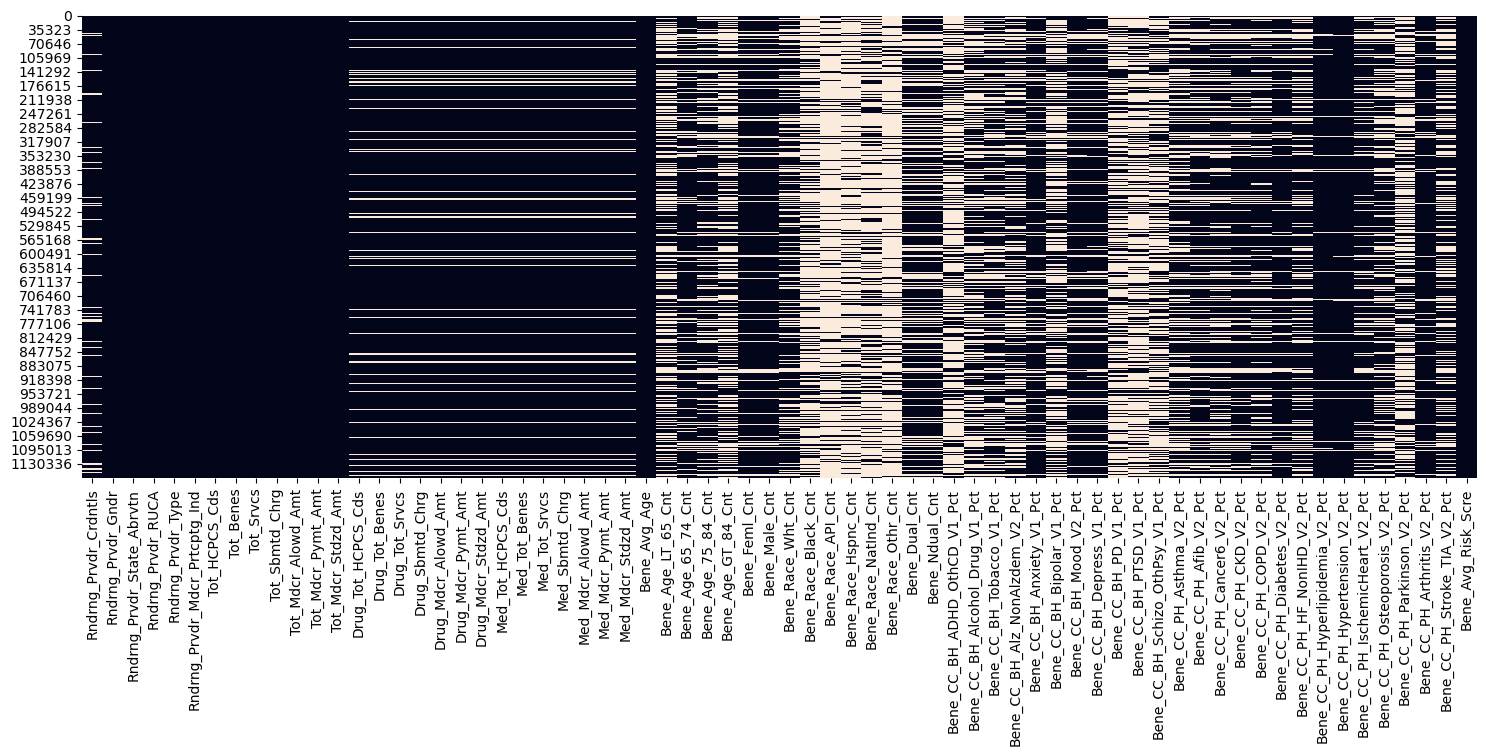

In [69]:
plt.figure(figsize=(18, 6))
sns.heatmap(data.isnull(), cbar=False)

### Checking Race Field

In [70]:
data[data.columns[data.columns.str.contains('Race')]].notnull().any(axis=1).value_counts()

True     826906
False    338743
dtype: int64

### Removing rows with all null race

In [71]:
data = data[data[data.columns[data.columns.str.contains('Race')]].notnull().any(axis=1)].reset_index(drop = True).copy()

### Removing rows with missing provider credentials

In [72]:
data = data.dropna(subset=['Rndrng_Prvdr_Crdntls']).reset_index(drop = True).copy()

## Constant Columns

In [73]:
data.nunique()[data.nunique()==1]

Series([], dtype: int64)

## Duplicate Rows

In [74]:
data.duplicated().sum()

0

## Distribution of Numeric Values

In [75]:
data.describe().T[:35]

,count,mean,std,min,25%,50%,75%,max
Rndrng_Prvdr_RUCA,764340.00,1.47,3.48,1.00,1.00,1.00,1.00,99.00
Tot_HCPCS_Cds,765761.00,33.57,31.89,1.00,12.00,24.00,44.00,525.00
Tot_Benes,765761.00,362.08,663.37,11.00,104.00,211.00,397.00,184281.00
Tot_Srvcs,765761.00,2865.38,18575.51,11.00,239.00,613.00,1710.00,4230230.00
Tot_Sbmtd_Chrg,765761.00,407404.55,1044422.32,58.50,67379.00,176703.31,407662.58,72055263.75
Tot_Mdcr_Alowd_Amt,765761.00,130513.42,376096.90,24.68,22477.98,54767.27,123683.76,55975629.82
Tot_Mdcr_Pymt_Amt,765761.00,100865.33,300329.41,0.00,17068.66,41871.27,94585.27,49866053.01
Tot_Mdcr_Stdzd_Amt,765761.00,99657.48,298126.84,0.00,16987.67,41629.92,93520.38,49842130.56
Drug_Tot_HCPCS_Cds,671064.00,1.98,6.51,0.00,0.00,0.00,1.00,150.00
Drug_Tot_Benes,671064.00,21.69,63.89,0.00,0.00,0.00,13.00,6390.00


In [76]:
data.describe().T[35:]

,count,mean,std,min,25%,50%,75%,max
Bene_Dual_Cnt,616742.00,82.59,158.26,0.00,23.00,43.00,85.00,30314.00
Bene_Ndual_Cnt,616742.00,337.63,619.55,0.00,95.00,193.00,368.00,163640.00
Bene_CC_BH_ADHD_OthCD_V1_Pct,220844.00,1.83,4.66,0.00,0.00,0.00,2.00,75.00
Bene_CC_BH_Alcohol_Drug_V1_Pct,505756.00,10.84,8.83,0.00,5.00,9.00,14.00,75.00
Bene_CC_BH_Tobacco_V1_Pct,572699.00,13.54,8.75,0.00,8.00,12.00,18.00,75.00
Bene_CC_BH_Alz_NonAlzdem_V2_Pct,525256.00,14.77,13.15,0.00,6.00,10.00,21.00,75.00
Bene_CC_BH_Anxiety_V1_Pct,695592.00,30.85,12.23,0.00,22.00,29.00,37.00,75.00
Bene_CC_BH_Bipolar_V1_Pct,398805.00,8.11,9.16,0.00,3.00,6.00,9.00,75.00
Bene_CC_BH_Mood_V2_Pct,699279.00,32.16,13.81,0.00,22.00,29.00,39.00,75.00
Bene_CC_BH_Depress_V1_Pct,689280.00,28.93,12.69,0.00,20.00,27.00,35.00,75.00


### Reclassifying RUCA as str

In [77]:
data['Rndrng_Prvdr_RUCA'].value_counts()

1.00     674376
4.00      39263
2.00      15406
7.00      11625
1.10      10409
10.00      4096
5.00       2457
4.10       2182
99.00       848
7.10        758
3.00        743
8.00        633
7.20        354
2.10        332
9.00        249
6.00        214
10.20       135
10.10       119
5.10         68
10.30        46
8.20         22
8.10          5
Name: Rndrng_Prvdr_RUCA, dtype: int64

In [78]:
data['Rndrng_Prvdr_RUCA'] = data['Rndrng_Prvdr_RUCA'].astype(str)

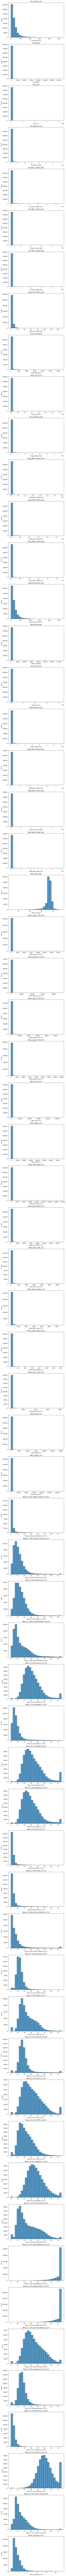

In [79]:
numeric_cols = data.select_dtypes(include=[np.number]).columns

fig, axs = plt.subplots(nrows=len(numeric_cols), figsize=(8, 6*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], ax=axs[i], bins = 25)
    axs[i].set_title(col)

## Outlier Exploration

In [80]:
def sd_outlier_high(col):
    data_col = data[col]
    mean = np.mean(data_col)
    sd = np.std(data_col)
    return data_col[ (data_col > mean + 3*sd)]

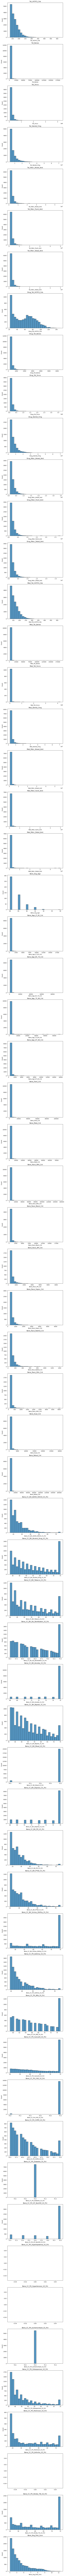

In [81]:
fig, axs = plt.subplots(nrows=len(numeric_cols), figsize=(8, 6*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    sns.histplot(sd_outlier_high(col), ax=axs[i], bins = 25)
    axs[i].set_title(col)

# Feature Engineering

In [82]:
categorical_cols = data.select_dtypes(include=[object]).columns

In [83]:
categorical_cols

Index(['Rndrng_Prvdr_Crdntls', 'Rndrng_Prvdr_Gndr',
       'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_RUCA', 'Rndrng_Prvdr_Type',
       'Rndrng_Prvdr_Mdcr_Prtcptg_Ind'],
      dtype='object')

## Cleaning Up Categorical Features

In [84]:
data[categorical_cols].nunique()

Rndrng_Prvdr_Crdntls             12092
Rndrng_Prvdr_Gndr                    2
Rndrng_Prvdr_State_Abrvtn           61
Rndrng_Prvdr_RUCA                   23
Rndrng_Prvdr_Type                   92
Rndrng_Prvdr_Mdcr_Prtcptg_Ind        2
dtype: int64

### Credentials

In [85]:
data['Rndrng_Prvdr_Crdntls'].value_counts()

MD                   211234
M.D.                 206552
PA-C                  33970
D.O.                  28073
CRNA                  24386
                      ...  
O.T.R.,C.H.T.             1
APRN-RX, MSN, MPH         1
RN, FNP, CNS              1
PA AA                     1
D.D.S., MPA, MAED         1
Name: Rndrng_Prvdr_Crdntls, Length: 12092, dtype: int64

### Keeping Primary Credentials

In [86]:
data['Rndrng_Prvdr_Crdntls'] = data['Rndrng_Prvdr_Crdntls'].str.split(',').str[0]

### Removing '.'

In [87]:
data['Rndrng_Prvdr_Crdntls'] = data['Rndrng_Prvdr_Crdntls'].str.replace('.','', regex = True)

### Fuzzy Clustering of Credentials

In [88]:
credentials = data['Rndrng_Prvdr_Crdntls'].unique()

# Vectorize the similarity calculations
credentials_array = np.array(credentials)
similarities = np.array([fuzz.token_sort_ratio(credentials_array[i], credentials_array[j]) for i in range(len(credentials)) for j in range(len(credentials))]).reshape(len(credentials), len(credentials))
# Perform hierarchical clustering
Z = linkage(similarities, method='ward')
# Form flat clusters
clusters = fcluster(Z, 0.5, criterion='distance')
# Assign cluster labels to credentials
credential_clusters = dict(zip(credentials, clusters))

In [89]:
data['Credential_Cluster'] = data['Rndrng_Prvdr_Crdntls'].map(credential_clusters)

### Major Credentials

In [90]:
major_credential_pattern = '|'.join(['MD', 'DO', 'RN', 'NP', 'PA', 'PharmD', 'DPM', 'DDS', 'DMD', 'CRNA', 'APRN', 'CNS', 'DC', 'OD', 'AuD', 'PT', 'OT', 'SLP', 'LCMHC', 'LCSW'])

In [91]:
data['Major_Credential'] = np.where(data['Rndrng_Prvdr_Crdntls'].str.contains(major_credential_pattern, case = False), 1, 0)

In [92]:
data = data.drop('Rndrng_Prvdr_Crdntls', axis=1).copy()

## Encoding Categorical Variables


In [93]:
categorical_cols = data.select_dtypes(include=[object]).columns

In [94]:
data = pd.get_dummies(data,columns = categorical_cols, drop_first = True).copy()

In [95]:
np.save('numerical_cols.npy', numeric_cols)

# Export Cleaned Data

In [96]:
data.to_pickle('data.pkl')